<a href="https://colab.research.google.com/github/ChethaniDilhari/sign-language-detection-with-media-pipe/blob/main/signDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

     |████████████████████████████████| 394.3 MB 9.8 kB/s 
     |████████████████████████████████| 394.3 MB 12 kB/s 
     |████████████████████████████████| 32.7 MB 157 kB/s 
     |████████████████████████████████| 462 kB 32.1 MB/s 
     |████████████████████████████████| 3.8 MB 42.9 MB/s 
     |████████████████████████████████| 2.9 MB 38.4 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68714 sha256=4cea13668b6aa39f2e8c6a237e9449fa5ead88bb3324d6c44b2526094327a3b1
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.43.0
    Uninstalling grpcio-1.43.0:
      Successfully uninstalled grpcio-1.43.0

In [2]:
!pip install mediapipe 

In [3]:
!pip uninstall opencv-python
!pip install opencv-contrib-python

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python-4.1.2.30.dist-info/*
Proceed (y/n)? n


In [4]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import cv2 #openCv
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
import io
from base64 import b64decode, b64encode

In [5]:
#xtracting keypoints using Media pipe

mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [6]:
#We get the image from webcam using openCV video capture, in BGR format. Therefor we need to convert it to RGB to be fed into MediaPipe model to do the detection. 
#After fedding and classification, we can convert it back to BGR

def mediapipe_detection(image, model):
    print("entered mediapipe_detection")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR CONVERSION RGB 2 BGR
    return image, results
    print("left mediapipe_detection")

In [7]:
#draw landamrks on the image 
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [8]:
def draw_styled_landmarks(image, results):
    
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

javascript helper function to make converting between different image data types and formats.

function to convert the JavaScript object into an OpenCV image

In [9]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [10]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [11]:

from google.colab.patches import cv2_imshow

In [16]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

  while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
        
    # Make detections
    image, results = mediapipe_detection(img, holistic) #image and the model are given as inputs
    print(results)
        
    # Draw landmarks
    draw_styled_landmarks(image, results)

    # Show to screen
    #cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        #if cv2.waitKey(10) & 0xFF == ord('q'):
          #  break
    

<IPython.core.display.Javascript object>

entered mediapipe_detection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
entered mediapipe_detection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
entered mediapipe_detection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
entered mediapipe_detection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
entered mediapipe_detection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
entered mediapipe_detection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
entered mediapipe_detection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
entered mediapipe_detection
<class 'mediapipe.python.solution_base.SolutionOutputs'>


In [17]:
draw_landmarks(img, results)

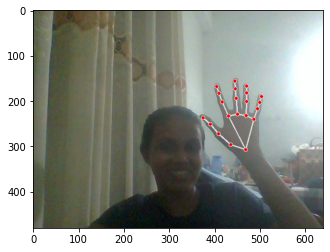

In [18]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [19]:
# Extract Keypoint Values

#no of landkarks in one hand
len(results.left_hand_landmarks.landmark)

21

In [20]:
#here is the reslut set for left hand
results.left_hand_landmarks.landmark

[x: 0.7340667247772217
y: 0.6398239731788635
z: 3.180116721068771e-07
, x: 0.682346761226654
y: 0.6174106597900391
z: -0.014745072461664677
, x: 0.6392732262611389
y: 0.5677636861801147
z: -0.020205767825245857
, x: 0.6115498542785645
y: 0.5229580998420715
z: -0.024141209200024605
, x: 0.5871639847755432
y: 0.4944724142551422
z: -0.027456151321530342
, x: 0.6739689111709595
y: 0.4858379065990448
z: -0.012145551852881908
, x: 0.6519269943237305
y: 0.4218407869338989
z: -0.021399784833192825
, x: 0.641204833984375
y: 0.38272401690483093
z: -0.028832845389842987
, x: 0.6342724561691284
y: 0.3510369062423706
z: -0.03443848714232445
, x: 0.7057722806930542
y: 0.4778360426425934
z: -0.013297328725457191
, x: 0.7010446190834045
y: 0.40554195642471313
z: -0.020727939903736115
, x: 0.6981284022331238
y: 0.3604580760002136
z: -0.02794000506401062
, x: 0.6965499520301819
y: 0.32560229301452637
z: -0.03323383629322052
, x: 0.7348810434341431
y: 0.48431888222694397
z: -0.016657976433634758
, x: 0.7

In [21]:
#we can get coordinates values of each point with the array indexes form 0-20
results.left_hand_landmarks.landmark[0]

x: 0.7340667247772217
y: 0.6398239731788635
z: 3.180116721068771e-07

taking x,y,z values of each keypoint in a hand and store them in a matrix(21,3). hidden keypoints are represented by zero(assign zero to keypoints which can not seen in the image)

In [22]:
#take the left 21 keypoint values of x,y,z into an array and 2 places for sin and cos values
def extract_left_keypoints(results):
    lh = np.array([[res.x, res.y, res.z, 0, 0] for res in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else np.zeros((21,5))
    return lh
#take the right 21 keypoint values of x,y,z into an array
def extract_right_keypoints(results):
    rh = np.array([[res.x, res.y, res.z, 0, 0] for res in results.right_hand_landmarks.landmark])if results.right_hand_landmarks else np.zeros((21,5))
    return rh

In [23]:
result_left_test = extract_left_keypoints(results)
result_right_test = extract_right_keypoints(results)

In [24]:
result_left_test
#comming with e values. all are <0

array([[ 7.34066725e-01,  6.39823973e-01,  3.18011672e-07,
         0.00000000e+00,  0.00000000e+00],
       [ 6.82346761e-01,  6.17410660e-01, -1.47450725e-02,
         0.00000000e+00,  0.00000000e+00],
       [ 6.39273226e-01,  5.67763686e-01, -2.02057678e-02,
         0.00000000e+00,  0.00000000e+00],
       [ 6.11549854e-01,  5.22958100e-01, -2.41412092e-02,
         0.00000000e+00,  0.00000000e+00],
       [ 5.87163985e-01,  4.94472414e-01, -2.74561513e-02,
         0.00000000e+00,  0.00000000e+00],
       [ 6.73968911e-01,  4.85837907e-01, -1.21455519e-02,
         0.00000000e+00,  0.00000000e+00],
       [ 6.51926994e-01,  4.21840787e-01, -2.13997848e-02,
         0.00000000e+00,  0.00000000e+00],
       [ 6.41204834e-01,  3.82724017e-01, -2.88328454e-02,
         0.00000000e+00,  0.00000000e+00],
       [ 6.34272456e-01,  3.51036906e-01, -3.44384871e-02,
         0.00000000e+00,  0.00000000e+00],
       [ 7.05772281e-01,  4.77836043e-01, -1.32973287e-02,
         0.00000000e+00

In [25]:
result_right_test

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [26]:

#getting x, y values of the fingeer tips and their hypotenuse(wikarnaya) according to the wrist as origin
#all x values are substracting from wrist's x value
#all wrist's y value is substracting from all y values
 

#Thumb finger tip
ax=result_left_test[0,0]-result_left_test[4,0]
ay=result_left_test[0,1]-result_left_test[4,1]
app=np.sqrt([np.power(ax,2)+np.power(ay,2)])
ap=app[0]

bx=result_left_test[0,0]-result_left_test[8,0]
by=result_left_test[0,1]-result_left_test[8,1]
bpp=np.sqrt([np.power(bx,2)+np.power(by,2)])
bp=bpp[0]

cx=result_left_test[0,0]-result_left_test[12,0]
cy=result_left_test[0,1]-result_left_test[12,1]
cpp=np.sqrt([np.power(cx,2)+np.power(cy,2)])
cp=cpp[0]

dx=result_left_test[0,0]-result_left_test[16,0]
dy=result_left_test[0,1]-result_left_test[16,1]
dpp=np.sqrt([np.power(dx,2)+np.power(dy,2)])
dp=dpp[0]

ex=result_left_test[0,0]-result_left_test[20,0]
ey=result_left_test[0,1]-result_left_test[20,1]
epp=np.sqrt([np.power(ex,2)+np.power(ey,2)])
ep=epp[0]

left_finger_tips= np.array([[ax,ay,ap],[bx,by,bp],[cx,cy,cp],[dx,dy,dp],[ex,ey,ep]])

fx=result_right_test[0,0]-result_right_test[4,0]
fy=result_right_test[0,1]-result_right_test[4,1]
fpp=np.sqrt([np.power(fx,2)+np.power(fy,2)])
fp=fpp[0]

gx=result_right_test[0,0]-result_right_test[8,0]
gy=result_right_test[0,1]-result_right_test[8,1]
gpp=np.sqrt([np.power(gx,2)+np.power(gy,2)])
gp=gpp[0]

hx=result_right_test[0,0]-result_right_test[12,0]
hy=result_right_test[0,1]-result_right_test[12,1]
hpp=np.sqrt([np.power(hx,2)+np.power(hy,2)])
hp=hpp[0]

ix=result_right_test[0,0]-result_right_test[16,0]
iy=result_right_test[0,1]-result_right_test[16,1]
ipp=np.sqrt([np.power(ix,2)+np.power(iy,2)])
ip=ipp[0]

jx=result_right_test[0,0]-result_right_test[20,0]
jy=result_right_test[0,1]-result_right_test[20,1]
jpp=np.sqrt([np.power(jx,2)+np.power(jy,2)])
jp=jpp[0]

right_finger_tips= np.array([[fx,fy,fp],[gx,gy,gp],[hx,hy,hp],[ix,iy,ip],[jx,jy,jp]])


In [27]:
left_finger_tips

array([[ 0.14690274,  0.14535156,  0.20665791],
       [ 0.09979427,  0.28878707,  0.30554356],
       [ 0.03751677,  0.31422168,  0.31645343],
       [-0.00306386,  0.29044387,  0.29046003],
       [-0.05350459,  0.24279302,  0.24861857]])

In [28]:
right_finger_tips

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [29]:
#get sin cos values for each finger tips
#perpendicular(opposite side) - y distance
#adjacent side - x distance
arr_sin_left=np.array([0.0,1.0,2.0,3.0,4.0])
arr_cos_left=np.array([0.0,1.0,2.0,3.0,4.0])
arr_sin_right=np.array([0.0,1.0,2.0,3.0,4.0])
arr_cos_right=np.array([0.0,1.0,2.0,3.0,4.0])

for i in range(0,5):
  arr_sin_left[i]=left_finger_tips[i,1]/left_finger_tips[i,2]
  arr_cos_left[i]=left_finger_tips[i,0]/left_finger_tips[i,2]
  arr_sin_right[i]=right_finger_tips[i,1]/right_finger_tips[i,2] if right_finger_tips[i,1] or right_finger_tips[i,2] else 0
  arr_cos_right[i]=right_finger_tips[i,0]/right_finger_tips[i,2] if right_finger_tips[i,0] or right_finger_tips[i,2] else 0

 

In [30]:
arr_sin_left

array([0.7033438 , 0.94515842, 0.99294762, 0.99994437, 0.97656834])

In [31]:
arr_sin_right

array([0., 0., 0., 0., 0.])

In [32]:
result_left_test[4,3]=arr_sin_left[0]
result_left_test[8,3]=arr_sin_left[1]
result_left_test[12,3]=arr_sin_left[2]
result_left_test[16,3]=arr_sin_left[3]
result_left_test[20,3]=arr_sin_left[4]

result_right_test[4,3]=arr_sin_right[0]
result_right_test[8,3]=arr_sin_right[1]
result_right_test[12,3]=arr_sin_right[2]
result_right_test[16,3]=arr_sin_right[3]
result_right_test[20,3]=arr_sin_right[4]
  
result_left_test[4,4]=arr_cos_left[0]
result_left_test[8,4]=arr_cos_left[1]
result_left_test[12,4]=arr_cos_left[2]
result_left_test[16,4]=arr_cos_left[3]
result_left_test[20,4]=arr_cos_left[4]

result_right_test[4,4]=arr_cos_right[0]
result_right_test[8,4]=arr_cos_right[1]
result_right_test[12,4]=arr_cos_right[2]
result_right_test[16,4]=arr_cos_right[3]
result_right_test[20,4]=arr_cos_right[4]
  

In [33]:
result_left_test

array([[ 7.34066725e-01,  6.39823973e-01,  3.18011672e-07,
         0.00000000e+00,  0.00000000e+00],
       [ 6.82346761e-01,  6.17410660e-01, -1.47450725e-02,
         0.00000000e+00,  0.00000000e+00],
       [ 6.39273226e-01,  5.67763686e-01, -2.02057678e-02,
         0.00000000e+00,  0.00000000e+00],
       [ 6.11549854e-01,  5.22958100e-01, -2.41412092e-02,
         0.00000000e+00,  0.00000000e+00],
       [ 5.87163985e-01,  4.94472414e-01, -2.74561513e-02,
         7.03343805e-01,  7.10849838e-01],
       [ 6.73968911e-01,  4.85837907e-01, -1.21455519e-02,
         0.00000000e+00,  0.00000000e+00],
       [ 6.51926994e-01,  4.21840787e-01, -2.13997848e-02,
         0.00000000e+00,  0.00000000e+00],
       [ 6.41204834e-01,  3.82724017e-01, -2.88328454e-02,
         0.00000000e+00,  0.00000000e+00],
       [ 6.34272456e-01,  3.51036906e-01, -3.44384871e-02,
         9.45158420e-01,  3.26612248e-01],
       [ 7.05772281e-01,  4.77836043e-01, -1.32973287e-02,
         0.00000000e+00

In [34]:
results = np.concatenate([result_right_test, result_left_test])


In [35]:
final = results.flatten()

In [36]:
final.shape

(210,)

In [ ]:
#proposed model

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(10,210)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [ ]:
# storing data

# Path for data, numpy arrays
DATA_PATH = '/content/drive/MyDrive/ColabNotebooks/keypointData/'

# Actions to detect
actions = np.array(['mama', 'api', 'oba'])

# no of videos
no_sequences = 7

# Videos are going to be 30 frames in length
sequence_length = 60

# Folder start
start_folder = 0

In [ ]:

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # Loop through actions
    for action in actions:
        # Loop through sequences  videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length, sequence length
            for frame_num in range(sequence_length):
              
                image = cv2.imread('/content/drive/MyDrive/ColabNotebooks/keypointData/' + actions(0) + sequence')
                # Make detections
                results = mediapipe_detection(image, holistic)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

              

SyntaxError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# creating lables

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
label_map = {label:num for num, label in enumerate(actions)}

In [ ]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [ ]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [ ]:
#Building LSTM Neural Network

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(7,210)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))